# Based on:
- https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
- https://www.kaggle.com/code/honganzhu/cmi-piu-competition?scriptVersionId=201912528 Version44 LB0.492
- https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-features-eda

# Understanding the Task:

The aim of this competition is to predict the Severity Impairment Index (sii), which measures the level of problematic internet use among children and adolescents, based on physical activity data and other features.

sii is derived from `PCIAT-PCIAT_Total`, the sum of scores from the Parent-Child Internet Addiction Test (PCIAT: 20 questions, scored 0-5).

Target Variable (sii) is defined as:

- 0: None (PCIAT-PCIAT_Total from 0 to 30)
- 1: Mild (PCIAT-PCIAT_Total from 31 to 49)
- 2: Moderate (PCIAT-PCIAT_Total from 50 to 79)
- 3: Severe (PCIAT-PCIAT_Total 80 and more)

This makes sii an ordinal categorical variable with four levels, where the order of categories is meaningful.

Type of Machine Learning Problem we can use with sii as a target:

1. Ordinal classification (ordinal logistic regression, models with custom ordinal loss functions)
2. Multiclass classification (treat sii as a nominal categorical variable without considering the order)
3. Regression (ignore the discrete nature of categories and treat sii as a continuous variable, then round prediction)
4. Custom (e.g. loss functions that penalize errors based on the distance between categories)

We can also use `PCIAT-PCIAT_Total` as a continuous target variable, and implement regression on `PCIAT-PCIAT_Total` and then map predictions to sii categories.

Finally, another strategy involves predicting responses to each question of the Parent-Child Internet Addiction Test: i.e. pedict individual question scores as separate targets, sum the predicted scores to get the `PCIAT-PCIAT_Total` and map predictions to the corresponding sii category.

# Questions from the test
Note: Each question has rating from 0-5 ("does not apply" - "always")
- `PCIAT-PCIAT_01`: How often does your child disobey time limits you set for online use?
- `PCIAT-PCIAT_02`: How often does your child neglect household chores to spend more time online?
- `PCIAT-PCIAT_03`: How often does your child prefer to spend time online rather than with the rest of your family?
- `PCIAT-PCIAT_04`: How often does your child form new relationships with fellow online users?
- `PCIAT-PCIAT_05`: How often do you complain about the amount of time your child spends online?
- `PCIAT-PCIAT_06`: How often do your child's grades suffer because of the amount of time he or she spends online?
- `PCIAT-PCIAT_07`: How often does your child check his or her e-mail before doing something else?
- `PCIAT-PCIAT_08`: How often does your child seem withdrawn from others since discovering the Internet?
- `PCIAT-PCIAT_09`: How often does your child become defensive or secretive when asked what he or she does online?
- `PCIAT-PCIAT_10`: How often have you caught your child sneaking online against your wishes?
- `PCIAT-PCIAT_11`: How often does your child spend time along in his or her room playing on the computer?
- `PCIAT-PCIAT_12`: How often does your child receive strange phone calls from new "online" friends?
- `PCIAT-PCIAT_13`: How often does your child snap, yell, or act annoyed if bothered while online?
- `PCIAT-PCIAT_14`: How often does your child seem more tired and fatigued than he or she did before the Internet came along?
- `PCIAT-PCIAT_15`: How often does your child seem preoccupied with being back online when off-line?
- `PCIAT-PCIAT_16`: How often does your child throw tantrums with your interference about how long he or she spends online?
- `PCIAT-PCIAT_17`: How often does your child choose to spend time online rather than doing once enjoyed hobbies and/or outside interests?
- `PCIAT-PCIAT_18`: How often does your child become angry or belligerent when your place time limits on how much time he or shes is allowed to spend online?
- `PCIAT-PCIAT_19`: How often does your child choose to spend more time online than going out with friends?
- `PCIAT-PCIAT_20`: How often does your child feel depressed, moody, or nervous when off-line which seems to go away once back online?

# Thoughts on questions:
- Should every question have equal weight for the target?

# Notes on Successful approaches:
- The best performing public model uses Ensemble learning, specifically a **Voting Regressor**, which combines predictions from LightGBM, XGBoost and CatBoost. "This approach is beneficial as it leverages the strengths of multiple models, reducing overfitting and improving overall model performance."

In [1]:
import numpy as np
import pandas as pd
import os
import re

from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix  # Added confusion_matrix

# from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import matplotlib.cm as cm
import seaborn as sns

# from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim




# from colorama import Fore, Style
# from IPython.display import clear_output
import warnings
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
# from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
# from sklearn.impute import SimpleImputer, KNNImputer
# from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

# Examine CSV data only

In [3]:
# Use enums for seasons for efficiency, data integrity and ML compatibility
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

# using polars dataframes for speed and memory efficiency
train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

data_dict = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

train

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,nu

In [4]:
train.describe()

statistic,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,str,str,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,…,f64,f64,f64,f64,f64,str,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64
"""count""","""3960""","""3960""",3960.0,3960.0,"""2555""",2421.0,"""3310""",3022.0,3027.0,3076.0,898.0,2954.0,2967.0,2954.0,"""1308""",743.0,740.0,740.0,"""3346""",2322.0,2282.0,1074.0,1062.0,1074.0,1063.0,2310.0,2271.0,2305.0,2267.0,2307.0,2269.0,2324.0,2285.0,"""2145""",1991.0,1991.0,…,1991.0,1991.0,1991.0,1991.0,1991.0,"""475""",475.0,"""1721""",1721.0,"""2736""",2733.0,2734.0,2731.0,2731.0,2729.0,2732.0,2729.0,2730.0,2730.0,2733.0,2734.0,2731.0,2729.0,2732.0,2730.0,2728.0,2725.0,2728.0,2730.0,2733.0,2736.0,"""2618""",2609.0,2606.0,"""3540""",3301.0,2736.0
"""null_count""","""0""","""0""",0.0,0.0,"""1405""",1539.0,"""650""",938.0,933.0,884.0,3062.0,1006.0,993.0,1006.0,"""2652""",3217.0,3220.0,3220.0,"""614""",1638.0,1678.0,2886.0,2898.0,2886.0,2897.0,1650.0,1689.0,1655.0,1693.0,1653.0,1691.0,1636.0,1675.0,"""1815""",1969.0,1969.0,…,1969.0,1969.0,1969.0,1969.0,1969.0,"""3485""",3485.0,"""2239""",2239.0,"""1224""",1227.0,1226.0,1229.0,1229.0,1231.0,1228.0,1231.0,1230.0,1230.0,1227.0,1226.0,1229.0,1231.0,1228.0,1230.0,1232.0,1235.0,1232.0,1230.0,1227.0,1224.0,"""1342""",1351.0,1354.0,"""420""",659.0,1224.0
"""mean""",null,null,10.433586,0.372727,null,65.454771,null,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,null,4.989233,7.37027,27.581081,null,11.25969,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.61888,8.805635,0.620097,9.252775,0.785558,null,2.651431,6.719826,…,33.17338,20.02299,67.301883,34.389466,53.998726,null,2.178853,null,2.58955,null,2.370655,2.177762,2.399854,0.839253,2.297545,1.06369,0.586295,1.24652,1.062637,1.304793,1.685443,0.244599,1.340051,1.035505,1.499634,1.452346,1.62789,1.613636,1.158974,0.943652,27.896199,null,41.088923,57.763622,null,1.060588,0.580409
"""std""",null,null,3.574648,0.483591,null,22.341862,null,5.113934,7.473764,44.56904,5.567287,13.611226,13.665196,17.061225,null,2.014072,3.189662,17.707751,null,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,null,1.028267,92.586325,…,56.272346,70.21561,108.705918,84.050607,129.362539,null,0.849476,null,0.783937,null,1.673312,1.697117,1.588807,1.195601,1.705218,1.268282,1.049355,1.342582,1.258797,1.331715,1.543074,0.522956,1.411156,1.301712,1.492929,1.4956,1.445622,1.529178,1.343661,1.18546,20.338853,null,10.427433,13.196091,null,1.094875,0.771122
"""min""","""00008ff9""",null,5.0,0.0,null,25.0,null,0.0,33.0,0.0,18.0,0.0,27.0,0.0,null,0.0,0.0,0.0,null,0.0,0.0,0.0,1.0,0.

In [5]:
train.head()

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [6]:
len(train)

3960

### Examine values in training data but not in test data

In [7]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


### Although 'sii' is a discretized version of 'PCIAT-PCIAT_Total', since 'sii' is in our test set and 'PCIAT-PCIAT_Total' we will have to use 'sii' for classification. 

## Examine missing data


In [8]:
missing_percentage = (
    train.select((pl.col('sii').is_null().sum() / train.height) * 100)
    .item()
)

print(f"Percentage of missing values in 'sii': {missing_percentage:.2f}%")

Percentage of missing values in 'sii': 30.91%


### We see that ~31% of our data is missing values for the target. For now we will discard this. Although it's a lot to lose...

In [9]:
# filter rows with non-null target ('sii')
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

# Compute missing values and ratios
missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)

print(f"If we filter out data points with missing target values, we only have {len(supervised_usable)} data points left.")

If we filter out data points with missing target values, we only have 2736 data points left.


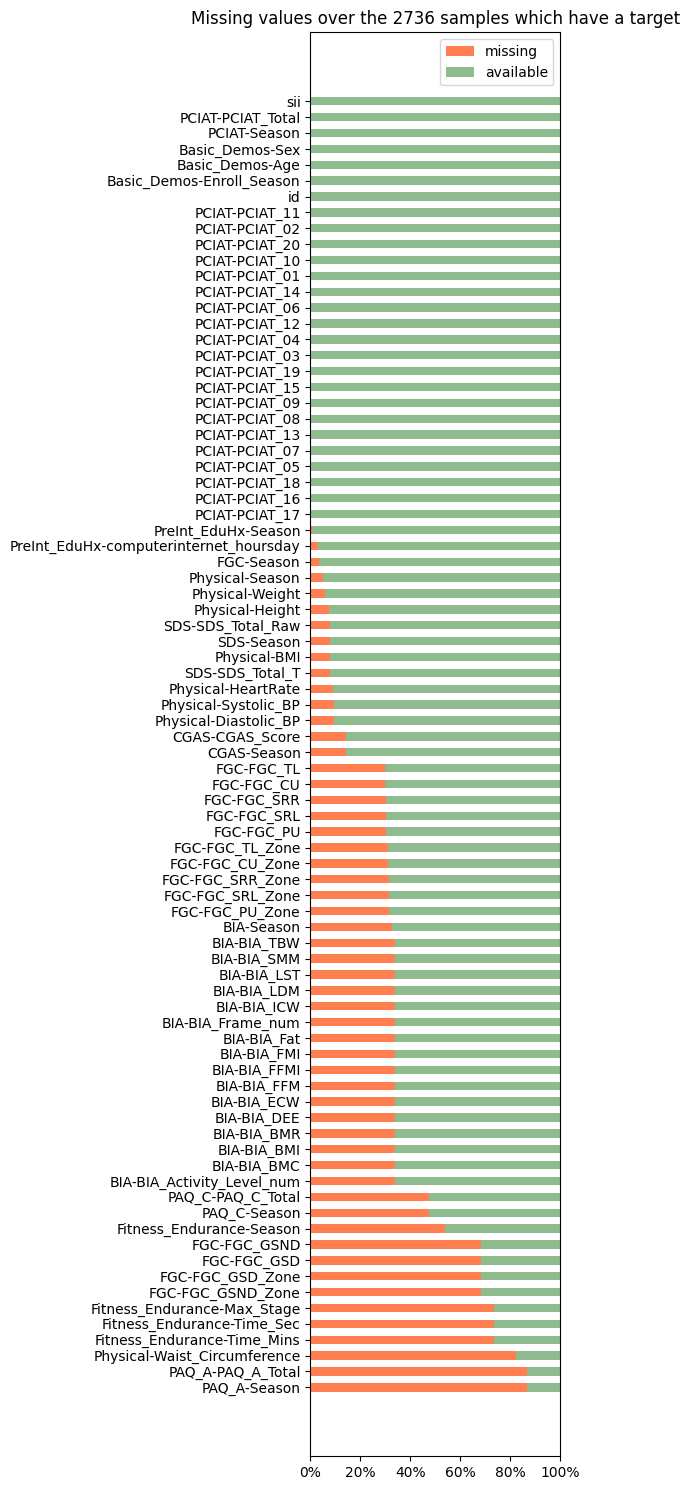

In [10]:
# Plot missing values

# Define the spacing for the bars
num_features = len(missing_count)
bar_positions = np.linspace(0, num_features * 1.5, num_features)  # Create evenly spaced positions with a multiplier

plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')

# Adjust the bar thickness with the `height` parameter
bar_height = 0.8  # Increase this value for thicker bars

# Create the horizontal bar chart with adjusted positions
plt.barh(bar_positions, missing_count.get_column('null_ratio'), color='coral', label='missing', height=bar_height)
plt.barh(bar_positions, 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available', height=bar_height)

# Adjust the y-ticks to match the new positions and add labels
plt.yticks(bar_positions, missing_count.get_column('feature'))

# Format the x-axis as percentages
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.tight_layout()  # Ensure everything fits nicely in the figure
plt.show()

In [11]:
compare_total_with_sii = train.select(pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null()).to_series().mean()
print(
    "All 'PCIAT-PCIAT_Total' nulls match nulls for 'sii'"
    if compare_total_with_sii== 1
    else "Nulls for 'PCIAT-PCIAT_Total' don't correspond 1:1 to nulls for 'sii'"
)

All 'PCIAT-PCIAT_Total' nulls match nulls for 'sii'


In [12]:
(train
 .select(pl.col('PCIAT-PCIAT_Total'))
 .group_by(train.get_column('sii'))
 .agg(pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),
      pl.col('PCIAT-PCIAT_Total').len().alias('count'))
 .sort('sii')
)

sii,PCIAT-PCIAT_Total min,PCIAT-PCIAT_Total max,count
i64,i64,i64,u32
null,null,null,1224
0,0,30,1594
1,31,49,730
2,50,79,378
3,80,93,34


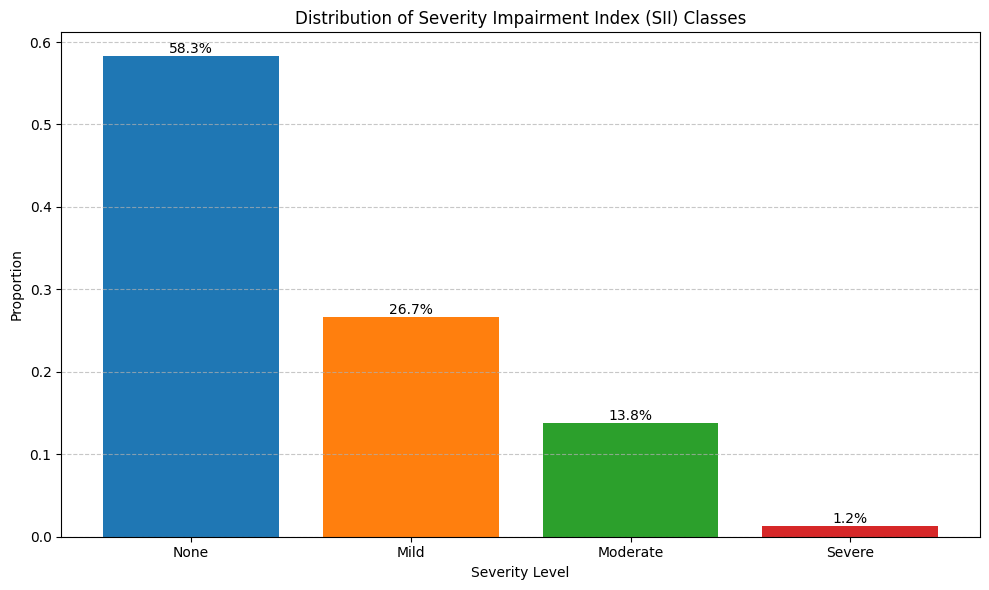

58.26% of non-null datapoints are of severity 'None'
1.24% of non-null datapoints are of severity 'Severe'


In [13]:
sii_map = {str(i): label for i, label in enumerate(target_labels)}

# Calculate distribution for all classes (excluding nulls)
class_distribution = (
    train
    .filter(pl.col('sii').is_not_null())  # Filter out nulls
    .group_by('sii')
    .agg(pl.count().alias('count'))       # Count occurrences of each class
    .sort('sii')                          # Sort by severity level
    .with_columns((pl.col('count') / pl.col('count').sum()).alias('ratio'))  # Calculate ratio
)


# Create bar chart
colors = cm.tab10(range(len(class_distribution)))

plt.figure(figsize=(10, 6))
bars = plt.bar([sii_map[str(int(x))] for x in class_distribution['sii'].to_list()], 
               class_distribution['ratio'].to_list(), color=colors)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}',
             ha='center', va='bottom')

# Customize the chart
plt.title('Distribution of Severity Impairment Index (SII) Classes')
plt.xlabel('Severity Level')
plt.ylabel('Proportion')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Extract the most and least frequent class info
most_frequent = class_distribution.sort('count', descending=True)
mf_class_name = most_frequent['sii'][0]
lf_class_name = most_frequent['sii'][3]
mf_class_ratio = most_frequent['ratio'][0]
lf_class_ratio = most_frequent['ratio'][3]

# Print the result with mapped label
print(f"{mf_class_ratio:.2%} of non-null datapoints are of severity '{sii_map[str(int(mf_class_name))]}'")
print(f"{lf_class_ratio:.2%} of non-null datapoints are of severity '{sii_map[str(int(lf_class_name))]}'")

### Above we can see that there is a class imbalance. 
Most datapoints have 'sii' class 0 ('None') and only about 1% are 3 ('Severe')

## Demographics

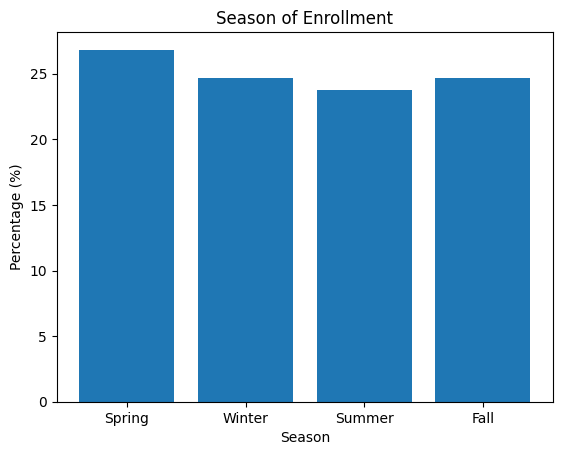

Spring: 26.8%
Winter: 24.7%
Fall: 24.7%
Summer: 23.8%


In [14]:
# Get the value counts and calculate percentages
vc = supervised_usable.get_column('Basic_Demos-Enroll_Season').value_counts()
vc = vc.with_columns(
    (vc['count'] / vc['count'].sum() * 100).alias('percentage')
)

# Plot the bar chart
plt.bar(vc.get_column('Basic_Demos-Enroll_Season'), vc.get_column('percentage'))
plt.title('Season of Enrollment')
plt.xlabel('Season')
plt.ylabel('Percentage (%)')
plt.show()

# Sort categories and percentages by descending order of percentage
categories = vc.get_column('Basic_Demos-Enroll_Season')
percentages = vc.get_column('percentage')
sorted_data = sorted(zip(categories, percentages), key=lambda x: x[1], reverse=True)

# Print the percentages in descending order
for category, percentage in sorted_data:
    print(f"{category}: {percentage:.1f}%")

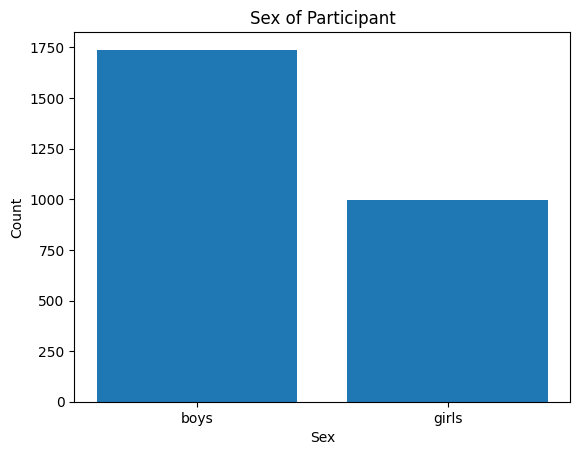

boys: 63.6%
girls: 36.4%


In [15]:
# Get the value counts
vc = supervised_usable.get_column('Basic_Demos-Sex').value_counts()
vc = vc.with_columns(
    (vc['count'] / vc['count'].sum() * 100).alias('percentage')
)

# Plot the bar chart
plt.bar(vc.get_column('Basic_Demos-Sex'), vc.get_column('count'))
plt.title('Sex of Participant')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(ticks=range(len(vc)), labels=['boys', 'girls'])  # Custom labels if needed
plt.show()

label_map = {0: "boys", 1: "girls"}
categories = [label_map[cat] for cat in vc.get_column('Basic_Demos-Sex')]
percentages = vc.get_column('percentage')

for category, percentage in zip(categories,percentages):
    print(f"{category}: {percentage:.1f}%")

### Close to 2/3rds of our usable dataset consists of boys, which can biase our data.

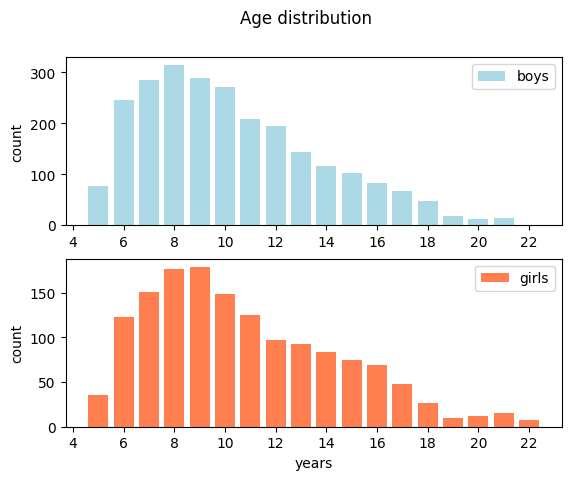

In [16]:
_, axs = plt.subplots(2, 1, sharex=True)  # sharex=True ensures both charts share the same x-axis

for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()

# Explicitly set the x-axis labels for the top chart
axs[0].tick_params(axis='x', which='both', labelbottom=True)

plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

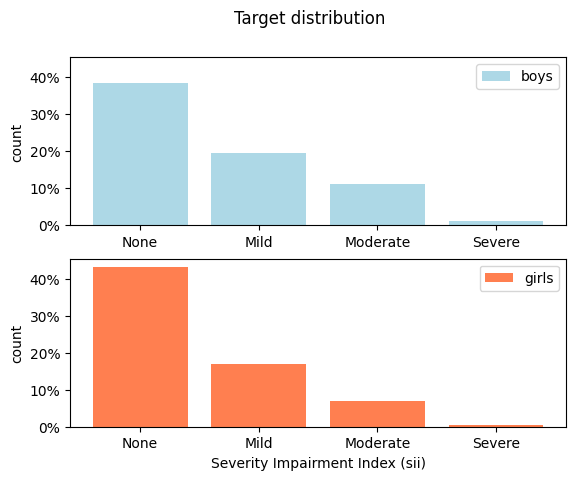

In [17]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()

# Explicitly set the x-axis labels for the top chart
axs[0].tick_params(axis='x', which='both', labelbottom=True)

plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

## Examine features most correlated with target

Physical-Height                           0.420765
Basic_Demos-Age                           0.409559
PreInt_EduHx-computerinternet_hoursday    0.374124
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
FGC-FGC_CU                                0.287494
BIA-BIA_BMI                               0.248060
Physical-BMI                              0.240858
SDS-SDS_Total_T                           0.237718
FGC-FGC_PU                                0.196006
BIA-BIA_Frame_num                         0.193631
FGC-FGC_GSD                               0.160472
Physical-Systolic_BP                      0.147081
FGC-FGC_GSND                              0.146813
FGC-FGC_TL                                0.136696
BIA-BIA_FFMI                              0.109694
Name: PCIAT-PCIAT_Total, dtype: float64


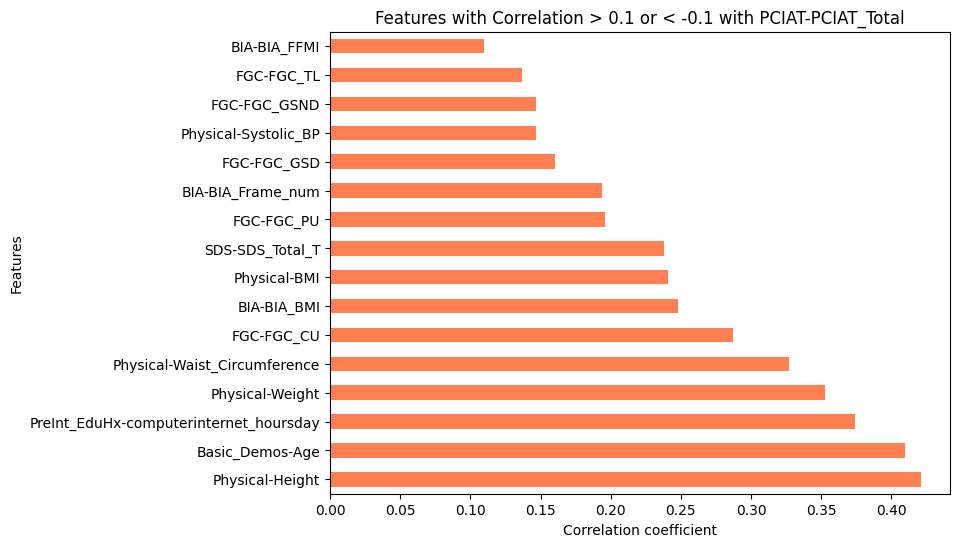

In [18]:
# Calculate correlation matrix
corr_matrix = supervised_usable.select([
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI','BIA-BIA_FMI', 'BIA-BIA_Fat','BIA-BIA_Frame_num','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST',
    'BIA-BIA_SMM','BIA-BIA_TBW'
    # Add other relevant columns as needed
]).to_pandas().corr()

# Filter correlations with `PCIAT-PCIAT_Total`
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

# Sort correlations
sorted_corr = filtered_corr.sort_values(ascending=False)

# Print filtered correlations
print(sorted_corr)

plt.figure(figsize=(8, 6))
sorted_corr.plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

### Note: Height is strongly correlated with the target but I think this is mostly because height in this category acts as a proxy for age.

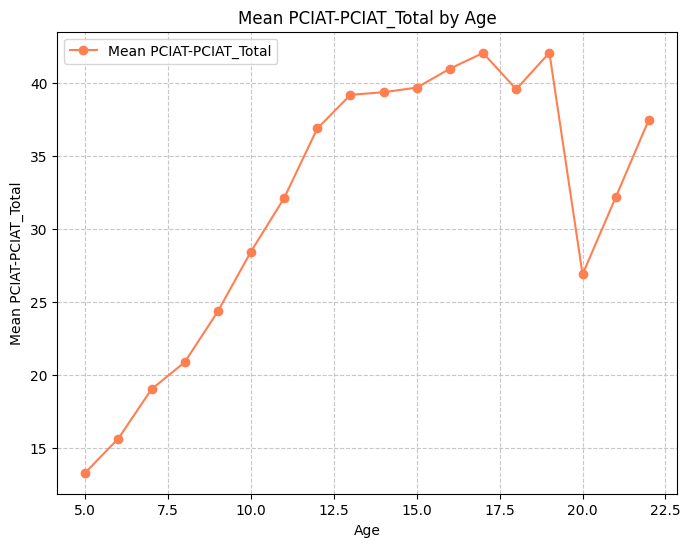

In [19]:
# Convert to pandas for easy manipulation
data = supervised_usable.to_pandas()

# Calculate the mean PCIAT-PCIAT_Total for each age
age_mean = data.groupby('Basic_Demos-Age')['PCIAT-PCIAT_Total'].mean().reset_index()

# Line plot for smoother visualization
plt.figure(figsize=(8, 6))
plt.plot(age_mean['Basic_Demos-Age'], age_mean['PCIAT-PCIAT_Total'], marker='o', color='coral', label='Mean PCIAT-PCIAT_Total')
plt.title('Mean PCIAT-PCIAT_Total by Age')
plt.xlabel('Age')
plt.ylabel('Mean PCIAT-PCIAT_Total')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Correlation between Age and Height: 0.89


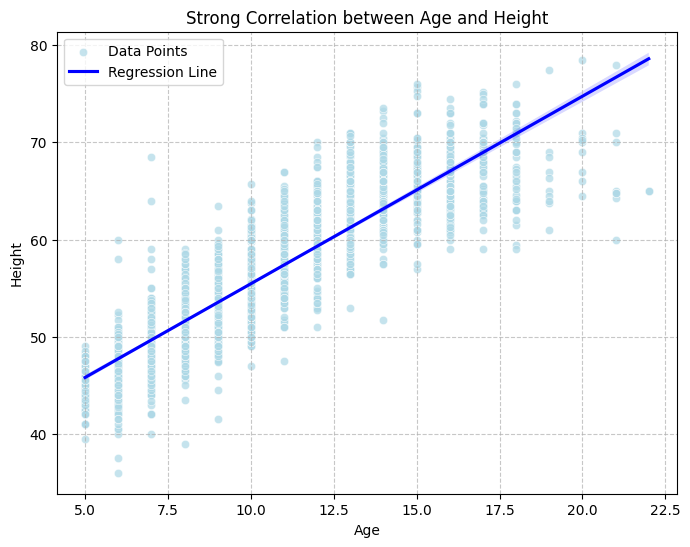

In [20]:
age_height_corr = data[['Basic_Demos-Age', 'Physical-Height']].corr().iloc[0, 1]
print(f"Correlation between Age and Height: {age_height_corr:.2f}")

# Scatterplot and regression line for Age vs Height
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data,
    x='Basic_Demos-Age',
    y='Physical-Height',
    color='lightblue',
    alpha=0.7,
    label='Data Points'
)
sns.regplot(
    data=data,
    x='Basic_Demos-Age',
    y='Physical-Height',
    scatter=False,
    color='blue',
    label='Regression Line'
)

# Add labels, title, and legend
plt.title('Strong Correlation between Age and Height')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Examine parquet file data

In [21]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…
287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.0,3695.0,32875000000000,1,3,53.0
287175,-0.703572,0.016187,0.15956,0.03598,14.12139,0.0,7.0,3695.0,32880000000000,1,3,53.0
287176,-0.209607,-0.4697,0.636573,0.097799,44.998573,0.0,7.0,3695.0,32885000000000,1,3,53.0


In [22]:
# Get all available parquet IDs
base_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'
available_ids = set(d.split('=')[1] for d in os.listdir(base_path) if d.startswith('id='))

# Check how many IDs from supervised_usable have parquet data
ids_in_df = set(supervised_usable['id'].to_list())
ids_with_parquet = ids_in_df.intersection(available_ids)

print(f"Total IDs in DataFrame: {len(ids_in_df)}")
print(f"Total IDs with parquet files: {len(available_ids)}")
print(f"IDs in DataFrame with parquet data: {len(ids_with_parquet)}")
print(f"Total data points not missing target but missing an associated parquet file: {len(ids_in_df) - len(ids_with_parquet)}")

# Let's try processing 3 IDs that we know have parquet files
ids_to_process = list(ids_with_parquet)[:3]
print("\nProcessing these IDs:", ids_to_process)

Total IDs in DataFrame: 2736
Total IDs with parquet files: 996
IDs in DataFrame with parquet data: 996
Total data points not missing target but missing an associated parquet file: 1740

Processing these IDs: ['9ebb73c7', '96de5f57', '22536a61']


## Notice that only 996 datapoints have an assciated parquet file

In [23]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9

    # find corresponding data from dataframe
    sample = supervised_usable.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    sii_value = sample.get_column('sii').item()
    
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}, sii={sii_value}')
    plt.show()

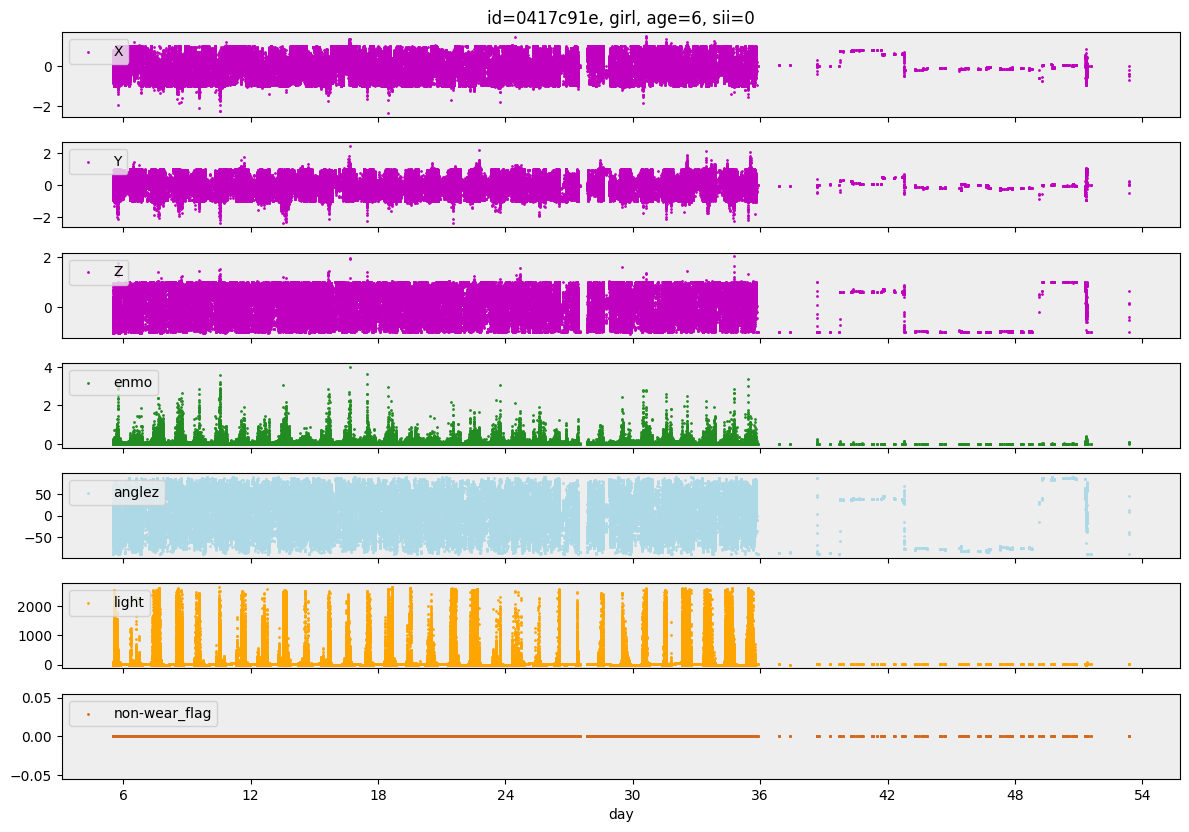

In [24]:
# Test on an example
analyze_actigraphy('0417c91e', only_one_week=False)

In [25]:
def process_parquet_file(id):
    """
    Process a single parquet file and extract statistical features using Polars.
    
    Args:
        id: ID of the subject/record to process (hexadecimal string)
        
    Returns:
        tuple: (computed_features, id)
    """
    path = f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet'
    df = pl.read_parquet(path)
    
    # Get numerical columns
    numeric_cols = [col for col in df.columns if df[col].dtype in [pl.Float32, pl.Float64, pl.Int32, pl.Int64]]
    
    # Calculate basic statistics for each numeric column
    basic_stats = []
    for col in numeric_cols:
        basic_stats.extend([
            pl.col(col).mean().alias(f'{col}_mean'),
            pl.col(col).std().alias(f'{col}_std'),
            pl.col(col).max().alias(f'{col}_max'),
            pl.col(col).min().alias(f'{col}_min'),
            pl.col(col).median().alias(f'{col}_median')
        ])
    
    # Calculate activity metrics
    features = df.select([
        *basic_stats,
        
        # Activity intensity features
        (pl.col('enmo').mean()).alias('avg_activity_intensity'),
        (pl.col('enmo').std()).alias('activity_variability'),
        (pl.col('enmo').max()).alias('peak_activity'),
        
        # Light exposure features
        (pl.col('light').mean()).alias('avg_light_exposure'),
        (pl.col('light').max()).alias('peak_light_exposure'),
        
        # Movement features using X, Y, Z axes
        (np.sqrt(
            pl.col('X')**2 + 
            pl.col('Y')**2 + 
            pl.col('Z')**2
        ).mean()).alias('avg_movement_magnitude'),
        
        # Time-based features
        (pl.col('time_of_day') / 3600e9).alias('hour'),
    ])
    
    # Add time-of-day based features
    time_features = df.with_columns([
        (pl.col('time_of_day') / 3600e9).alias('hour')
    ]).select([
        # Morning activity (6 AM - 12 PM)
        (pl.col('enmo')
         .filter((pl.col('hour') >= 6) & (pl.col('hour') < 12))
         .mean()
        ).alias('morning_activity'),
        
        # Afternoon activity (12 PM - 6 PM)
        (pl.col('enmo')
         .filter((pl.col('hour') >= 12) & (pl.col('hour') < 18))
         .mean()
        ).alias('afternoon_activity'),
        
        # Evening activity (6 PM - 12 AM)
        (pl.col('enmo')
         .filter((pl.col('hour') >= 18) & (pl.col('hour') < 24))
         .mean()
        ).alias('evening_activity'),
        
        # Night activity (12 AM - 6 AM)
        (pl.col('enmo')
         .filter((pl.col('hour') >= 0) & (pl.col('hour') < 6))
         .mean()
        ).alias('night_activity'),
        
        # Activity patterns
        (pl.col('non-wear_flag').mean()).alias('non_wear_percentage'),
        
        # Rest-activity pattern
        (pl.col('enmo')
         .filter(pl.col('light') < 50)  # assuming dark periods
         .mean()
        ).alias('rest_activity'),
        
        # Active periods
        (pl.col('enmo')
         .filter(pl.col('enmo') > pl.col('enmo').mean())
         .count()
        ).alias('active_periods')
    ])
    
    # Combine all features
    all_features = pl.concat([features, time_features], how='horizontal')
    
    # Convert to dictionary
    feature_dict = all_features.row(0, named=True)
    
    return feature_dict, id

def load_and_process_parquet_files(ids, n_workers=4):
    """
    Load and process multiple parquet files in parallel using Polars.
    
    Args:
        ids: List of IDs to process
        n_workers: Number of parallel workers
        
    Returns:
        pl.DataFrame: Polars DataFrame containing extracted features for each file
    """
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(tqdm(
            executor.map(process_parquet_file, ids),
            total=len(ids),
            desc="Processing parquet files"
        ))
    
    features_list, ids_list = zip(*results)
    df_features = pl.DataFrame(features_list)
    df_features = df_features.with_columns(pl.Series(name='id', values=ids_list))
    
    return df_features

In [26]:
# Get list of valid IDs (ones that have parquet files)
base_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'
available_ids = set(d.split('=')[1] for d in os.listdir(base_path) if d.startswith('id='))
ids_in_df = set(supervised_usable['id'].to_list())
valid_ids = list(ids_in_df.intersection(available_ids))

print(f"Processing all {len(valid_ids)} IDs with parquet data...")

# Start with a small test first
n_ids_to_test = len(valid_ids) # replace with all id's for final training
test_ids = valid_ids[:n_ids_to_test]

# Process all valid IDs
df_features = load_and_process_parquet_files(valid_ids)

# Save the features to avoid reprocessing
print("\nSaving features...")
df_features.write_parquet("actigraphy_features.parquet")

# Basic EDA
print("\nFeature summary statistics:")
print(df_features.describe())

# Show number of features extracted
print(f"\nNumber of features extracted: {len(df_features.columns)-1}")  # -1 for the ID column

# Display a few example features and their distributions
activity_features = [col for col in df_features.columns if 'activity' in col]
print("\nActivity-related features:")
for feature in activity_features:
    stats = df_features[feature].describe()
    print(f"\n{feature}:")
    print(stats)

Processing all 996 IDs with parquet data...


Processing parquet files: 100%|██████████| 996/996 [00:59<00:00, 16.72it/s]


Saving features...

Feature summary statistics:
shape: (9, 66)
┌────────────┬───────────┬──────────┬──────────┬───┬────────────┬───────────┬───────────┬──────────┐
│ statistic  ┆ X_mean    ┆ X_std    ┆ X_max    ┆ … ┆ non_wear_p ┆ rest_acti ┆ active_pe ┆ id       │
│ ---        ┆ ---       ┆ ---      ┆ ---      ┆   ┆ ercentage  ┆ vity      ┆ riods     ┆ ---      │
│ str        ┆ f64       ┆ f64      ┆ f64      ┆   ┆ ---        ┆ ---       ┆ ---       ┆ str      │
│            ┆           ┆          ┆          ┆   ┆ f64        ┆ f64       ┆ f64       ┆          │
╞════════════╪═══════════╪══════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪══════════╡
│ count      ┆ 996.0     ┆ 996.0    ┆ 996.0    ┆ … ┆ 996.0      ┆ 996.0     ┆ 996.0     ┆ 996      │
│ null_count ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0        │
│ mean       ┆ -0.062037 ┆ 0.473792 ┆ 1.672994 ┆ … ┆ 0.22199    ┆ 0.034464  ┆ 71254.966 ┆ null     │
│            ┆           ┆ 

In [45]:
# After processing, to join with original DataFrame:
df_combined = supervised_usable.join(df_features, on='id', how='inner')

df_combined.head()

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,non-wear_flag_max,non-wear_flag_min,non-wear_flag_median,light_mean,light_std,light_max,light_min,light_median,battery_voltage_mean,battery_voltage_std,battery_voltage_max,battery_voltage_min,battery_voltage_median,time_of_day_mean,time_of_day_std,time_of_day_max,time_of_day_min,time_of_day_median,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_max,relative_date_PCIAT_min,relative_date_PCIAT_median,avg_activity_intensity,activity_variability,peak_activity,avg_light_exposure,peak_light_exposure,avg_movement_magnitude,hour,morning_activity,afternoon_activity,evening_activity,night_activity,non_wear_percentage,rest_activity,active_periods
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,0.0,0.0,0.0,42.29631,208.168976,2633.25,0.0,6.926828,4053.578857,112.404037,4188.5,3824.0,4070.0,5.0462e13,1.9428e13,86110000000000,55000000000,5.3478e13,53.201683,14.244915,85.0,41.0,50.0,0.047388,0.106351,4.004276,42.29631,2633.25,0.958392,15.816667,0.039545,0.05136,0.056419,0.025262,0.0,0.044766,9451
"""001f3379""","""Spring""",13,1,"""Winter""",50,"""Summer""",22.279952,59.5,112.2,null,60,73,102,null,null,null,null,"""Summer""",12,0,16.5,2,17.9,2,6,0,10.0,1,11.0,1,8.0,0,"""Summer""",2,4.33036,30.1865,…,1.0,0.0,1.0,16.77198,95.327438,2597.800049,0.0,0.879005,3838.189453,155.573868,4175.0,3098.166748,3812.0,4.3212e13,2.4973e13,86395000000000,0,4.3310e13,79.435593,6.634319,91.0,68.0,79.0,0.011926,0.024331,2.952888,16.77198,2597.800049,1.001227,11.183333,0.012523,0.015033,0.01199,0.008165,0.655708,0.011191,42136
"""00f332d1""","""Winter""",14,0,"""Spring""",68,"""Spring""",17.168636,66.5,108.0,null,60,71,129,null,null,null,null,"""Spring""",16,0,18.4,1,20.9,2,22,1,3.5,0,5.5,0,13.0,1,"""Spring""",4,5.93056,17.1705,…,1.0,0.0,0.0,66.5634,286.916595,2611.0,0.0,7.172273,3848.583252,166.968582,4187.0,3098.166748,3818.0,4.3187e13,2.4949e13,86395000000000,0,4.3162e13,26.152903,6.932943,38.0,14.0,26.0,0.030255,0.104136,4.041167,66.5634,2611.0,0.980989,15.9,0.036799,0.05462,0.025501,0.00418,0.171246,0.025189,80946
"""01085eb3""","""Fall""",12,0,"""Winter""",58,"""Fall""",34.187282,60.5,178.0,null,67,81,119,null,null,null,null,"""Fall""",8,0,12.6,2,17.6,2,0,0,4.0,0,6.0,0,11.0,1,"""Fall""",1,5.15068,34.191,…,1.0,0.0,0.0,17.800735,73.023468,2650.5,0.0,6.677332,3849.650146,171.100159,4184.0,3098.166748,3827.833252,4.3384e13,2.5134e13,86395000000000,0,4.3555e13,49.910686,6.204417,61.0,39.0,50.0,0.032946,0.083798,4.097965,17.800735,2650.5,0.971947,16.3,0.045206,0.051756,0.030093,0.005381,0.03521,0.032506,79786
"""012cadd8""","""Spring""",9,0,"""Winter""",60,"""Fall""",17.089151,53.2,68.8,null,62,88,123,"""Fall""",null,null,null,"""Fall""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,0.0,0.0,54.893402,230.972397,2618.0,0.0,7.05916,3974.910645,119.525154,4157.0,3095.0,3994.0,4.3436e13,2.5410e13,86395000000000,0,4.4730e13,-1.168288

Top correlations with PCIAT-PCIAT_Total:
avg_movement_magnitude    0.245527
Y_min                     0.132174
non_wear_percentage       0.116704
non-wear_flag_mean        0.116704
time_of_day_std           0.111051
non-wear_flag_std         0.105993
X_min                     0.104843
non-wear_flag_median      0.102887
X_max                    -0.106178
light_std                -0.114579
X_std                    -0.131291
Y_max                    -0.138864
enmo_max                 -0.139928
peak_activity            -0.139928
evening_activity         -0.170843
enmo_median              -0.172526
rest_activity            -0.221594
enmo_std                 -0.222778
activity_variability     -0.222778
avg_activity_intensity   -0.223629
enmo_mean                -0.223629
morning_activity         -0.245367
afternoon_activity       -0.250618
Name: PCIAT-PCIAT_Total, dtype: float64


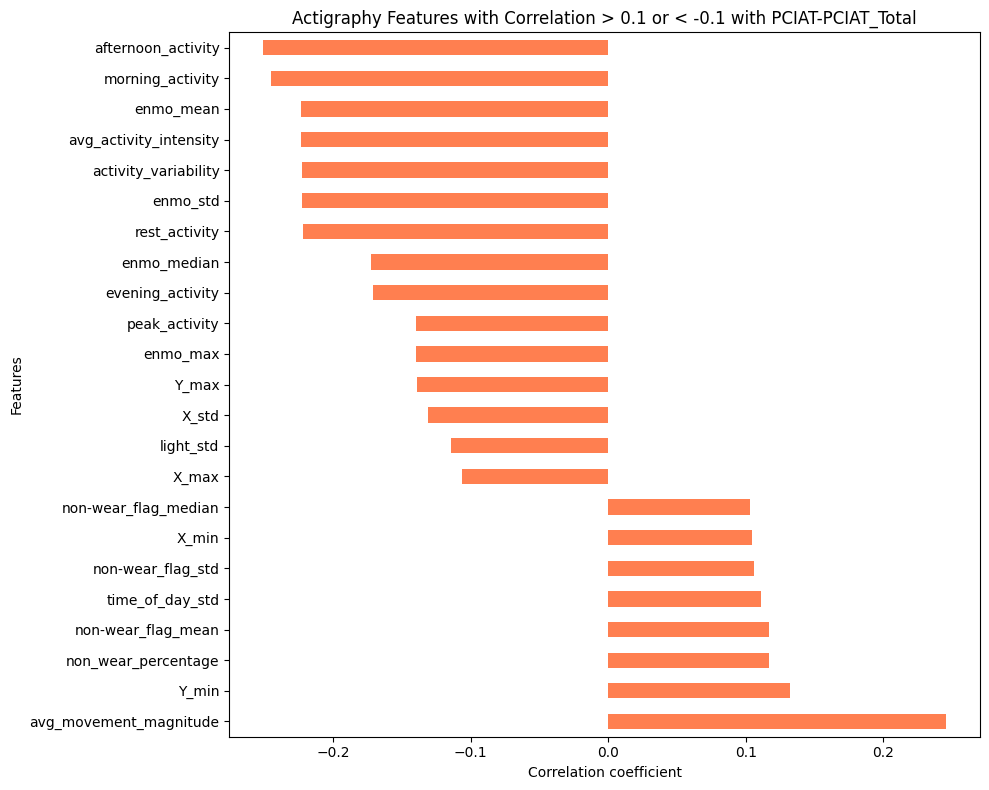


Total number of features: 64
Number of features with correlation > 0.1 or < -0.1: 23
Strongest positive correlation: 0.24552695396739094 (avg_movement_magnitude)
Strongest negative correlation: -0.2506184767978002 (afternoon_activity)


In [46]:
# First, let's join the new features with the target variable
df_new_features = (supervised_usable
    .select(['id', 'PCIAT-PCIAT_Total'])  # Only select ID and target
    .join(df_features, on='id', how='inner'))  # Join with our new features

# Calculate correlation matrix for new features only
# First, get all feature columns (excluding 'id' and target)
feature_cols = [col for col in df_features.columns if col != 'id']

# Calculate correlations
corr_matrix = df_new_features.select([
    'PCIAT-PCIAT_Total',
    *feature_cols  # Include all our new features
]).to_pandas().corr()

# Filter correlations with PCIAT-PCIAT_Total
pciat_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = pciat_corr[(pciat_corr > 0.1) | (pciat_corr < -0.1)]

# Sort correlations
sorted_corr = filtered_corr.sort_values(ascending=False)

# Print filtered correlations
print("Top correlations with PCIAT-PCIAT_Total:")
print(sorted_corr)

# Create visualization
plt.figure(figsize=(10, max(8, len(sorted_corr) * 0.3)))  # Adjust figure size based on number of features
sorted_corr.plot(kind='barh', color='coral')
plt.title('Actigraphy Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# Print some summary statistics
print(f"\nTotal number of features: {len(feature_cols)}")
print(f"Number of features with correlation > 0.1 or < -0.1: {len(filtered_corr)}")
print(f"Strongest positive correlation: {sorted_corr.iloc[0]} ({sorted_corr.index[0]})")
print(f"Strongest negative correlation: {sorted_corr.iloc[-1]} ({sorted_corr.index[-1]})")


Activity patterns across times of day:
shape: (9, 5)
┌────────────┬──────────────────┬────────────────────┬──────────────────┬────────────────┐
│ statistic  ┆ morning_activity ┆ afternoon_activity ┆ evening_activity ┆ night_activity │
│ ---        ┆ ---              ┆ ---                ┆ ---              ┆ ---            │
│ str        ┆ f64              ┆ f64                ┆ f64              ┆ f64            │
╞════════════╪══════════════════╪════════════════════╪══════════════════╪════════════════╡
│ count      ┆ 993.0            ┆ 996.0              ┆ 996.0            ┆ 991.0          │
│ null_count ┆ 1743.0           ┆ 1740.0             ┆ 1740.0           ┆ 1745.0         │
│ mean       ┆ 0.039003         ┆ 0.054226           ┆ 0.035932         ┆ 0.011643       │
│ std        ┆ 0.024998         ┆ 0.033365           ┆ 0.024351         ┆ 0.010328       │
│ min        ┆ 0.000025         ┆ 0.000226           ┆ 0.00001          ┆ 0.000008       │
│ 25%        ┆ 0.018844         ┆ 0.

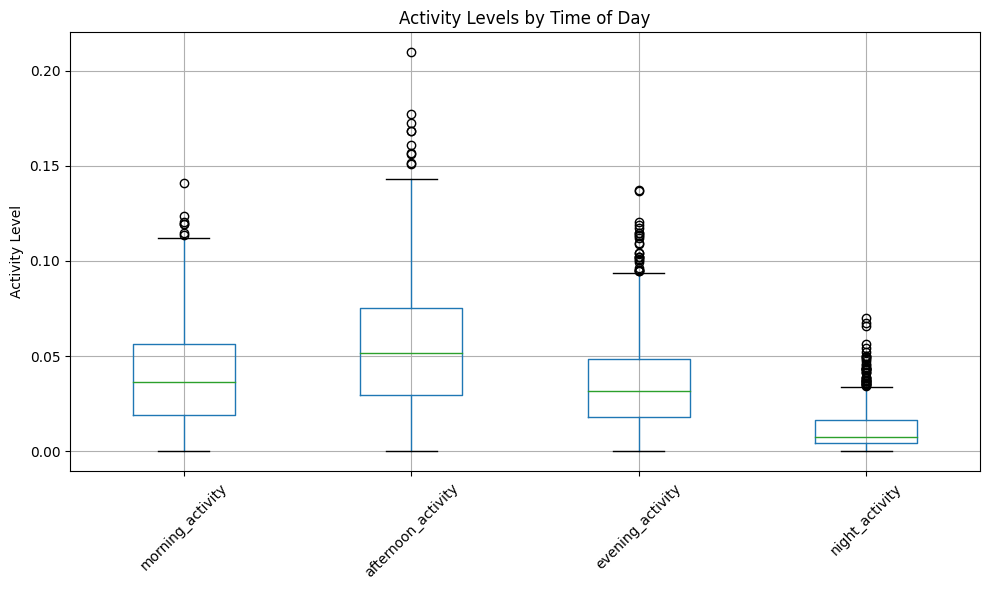

In [40]:
# Compare activity levels across different times of day
time_features = ['morning_activity', 'afternoon_activity', 'evening_activity', 'night_activity']
df_time_stats = df_combined.select(time_features).describe()
print("\nActivity patterns across times of day:")
print(df_time_stats)

# Visualize distribution of activity by time of day
plt.figure(figsize=(10, 6))
df_combined.select(time_features).to_pandas().boxplot()
plt.title('Activity Levels by Time of Day')
plt.ylabel('Activity Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

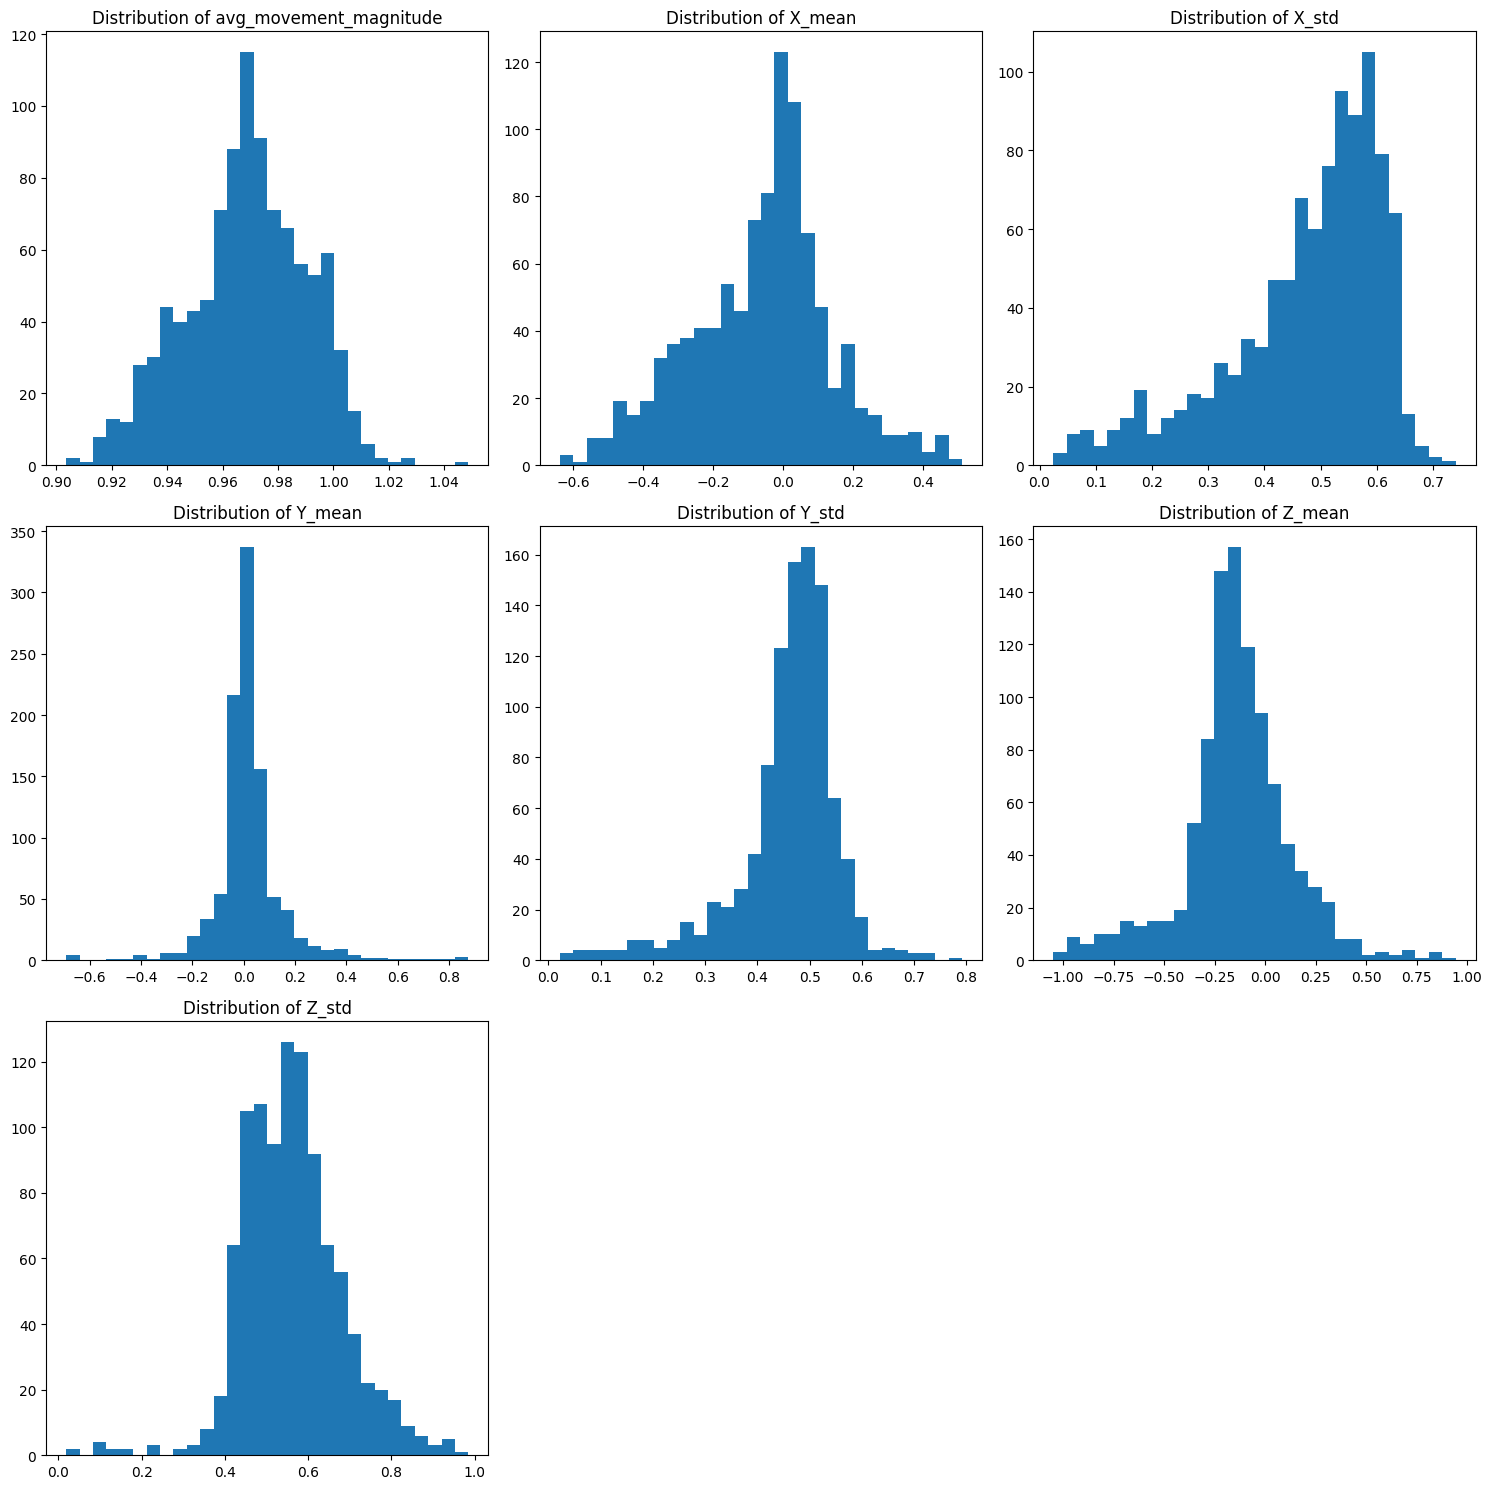

In [41]:
movement_cols = ['avg_movement_magnitude', 'X_mean', 'X_std', 'Y_mean', 'Y_std', 'Z_mean', 'Z_std']

# Analyze X, Y, Z movement patterns
plt.figure(figsize=(15, 15))
for i, col in enumerate(movement_cols, 1):
    plt.subplot(3, 3, i)
    values = df_combined[col].to_numpy()
    plt.hist(values, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

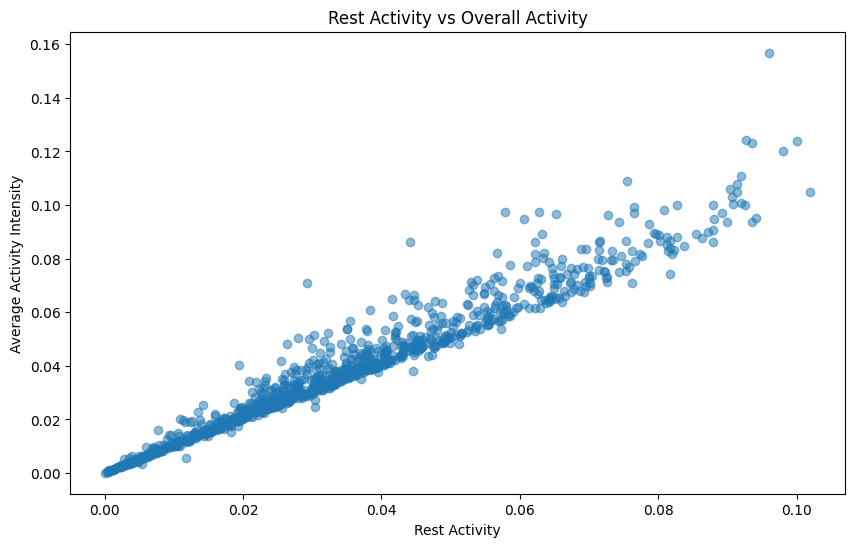

In [42]:
# Compare rest activity with overall activity
plt.figure(figsize=(10, 6))
plt.scatter(
    df_combined['rest_activity'].to_numpy(),
    df_combined['avg_activity_intensity'].to_numpy(),
    alpha=0.5
)
plt.xlabel('Rest Activity')
plt.ylabel('Average Activity Intensity')
plt.title('Rest Activity vs Overall Activity')
plt.show()

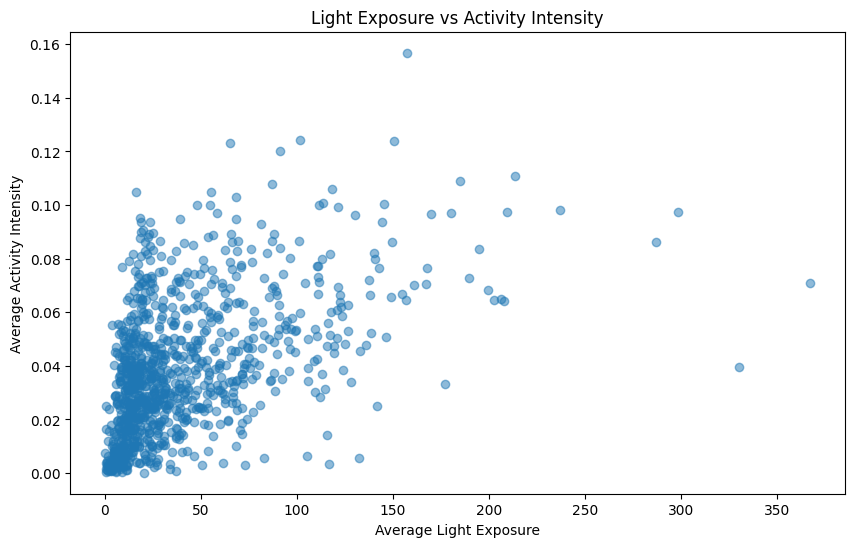

In [43]:
# Analyze relationship between light exposure and activity
plt.figure(figsize=(10, 6))
plt.scatter(
    df_combined['avg_light_exposure'].to_numpy(),
    df_combined['avg_activity_intensity'].to_numpy(),
    alpha=0.5
)
plt.xlabel('Average Light Exposure')
plt.ylabel('Average Activity Intensity')
plt.title('Light Exposure vs Activity Intensity')
plt.show()

# Make a quick model

Total number of features: 117
Numerical features: 107
Categorical features: 10

Validation Metrics:
Quadratic Weighted Kappa: 0.4283
Root Mean Squared Error: 16.8287

Top 20 Most Important Features:
                                    feature  importance
1                           Basic_Demos-Age    0.108168
57   PreInt_EduHx-computerinternet_hoursday    0.085707
7                           Physical-Height    0.050812
8                           Physical-Weight    0.028959
64                                    Y_std    0.019946
55                          SDS-SDS_Total_T    0.018612
54                        SDS-SDS_Total_Raw    0.017713
12                     Physical-Systolic_BP    0.017431
69                                    Z_std    0.015591
109                                    hour    0.014089
59                                    X_std    0.013200
18                               FGC-FGC_CU    0.012660
80                               anglez_max    0.012536
70               

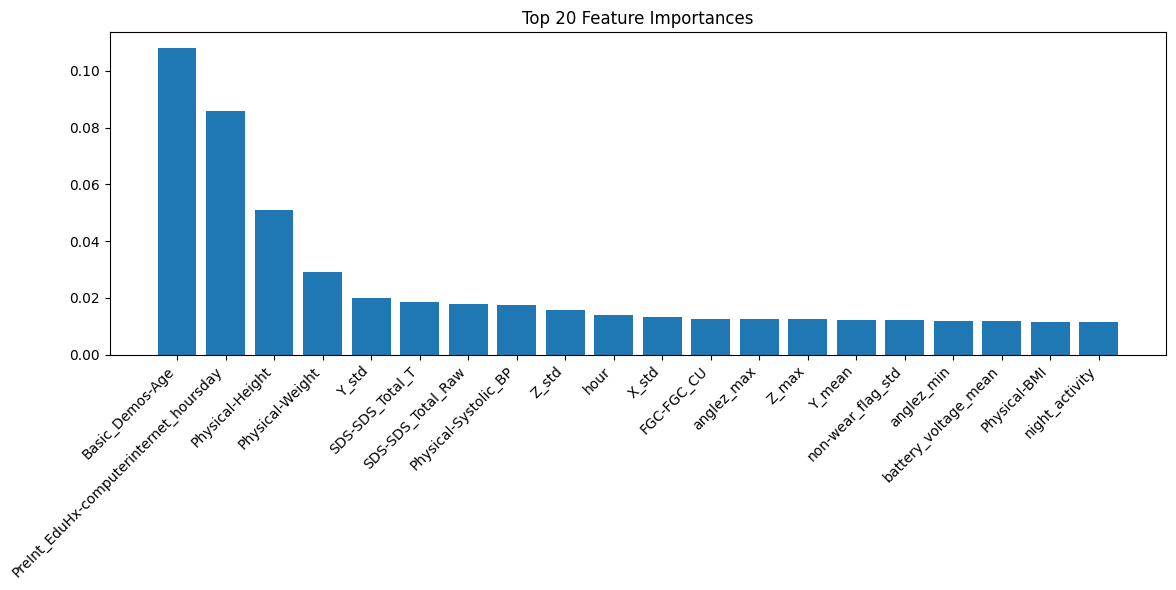

In [47]:
def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculate quadratic weighted kappa with proper label handling
    """
    # First round predictions and ensure they're integers
    y_true = np.round(y_true).astype(int)
    y_pred = np.round(y_pred).astype(int)
    
    # Get the range of labels
    min_rating = min(min(y_true), min(y_pred))
    max_rating = max(max(y_true), max(y_pred))
    N = max_rating - min_rating + 1
    
    # Create the confusion matrix (O matrix)
    O = confusion_matrix(y_true, y_pred, 
                        labels=range(min_rating, max_rating + 1))
    
    # Create weight matrix (W matrix)
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            W[i, j] = ((i-j)**2) / ((N-1)**2)
    
    # Create histogram vectors of each rating
    hist_true = np.histogram(y_true, bins=N, 
                           range=(min_rating-0.5, max_rating+0.5))[0]
    hist_pred = np.histogram(y_pred, bins=N,
                           range=(min_rating-0.5, max_rating+0.5))[0]
    
    # Create expected matrix (E matrix)
    outer_prod = np.outer(hist_true, hist_pred)
    E = outer_prod / np.sum(outer_prod) * np.sum(O)
    
    # Calculate kappa
    num = np.sum(W * O)
    den = np.sum(W * E)
    
    kappa = 1 - (num / den) if den != 0 else 0
    
    return kappa


def get_feature_columns(df):
    # Exclude the target variable, ID column, and any PCIAT-related columns
    exclude_patterns = ['id', 'PCIAT', 'sii']  # List of patterns to exclude
    
    # Filter out columns that contain any of the exclude patterns
    feature_cols = [col for col in df.columns 
                   if not any(pattern in col for pattern in exclude_patterns)]
    return feature_cols

def preprocess_data(df, features):
    X = df[features].copy()
    
    # Separate numerical and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(exclude=['int64', 'float64']).columns
    
    print(f"Numerical features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    
    # Handle numerical features
    if len(numeric_features) > 0:
        num_imputer = SimpleImputer(strategy='median')
        X[numeric_features] = num_imputer.fit_transform(X[numeric_features])
    
    # Handle categorical features
    if len(categorical_features) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])
        
        le_dict = {}
        for column in categorical_features:
            le = LabelEncoder()
            X[column] = le.fit_transform(X[column])
            le_dict[column] = le
    
    return X

# Convert polars DataFrame to pandas
df_combined_pandas = df_combined.to_pandas()

# Get all feature columns
features = get_feature_columns(df_combined_pandas)
print(f"Total number of features: {len(features)}")

# Prepare training data
X = preprocess_data(df_combined_pandas, features)
y = df_combined_pandas['PCIAT-PCIAT_Total']

# Remove any rows with NaN in target
mask = ~y.isna()
X = X[mask]
y = y[mask]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on validation set
val_preds = model.predict(X_val)

# Print metrics including QWK
print("\nValidation Metrics:")
print(f"Quadratic Weighted Kappa: {quadratic_weighted_kappa(y_val, val_preds):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_val, val_preds)):.4f}")

# Print feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Visualize feature importances
plt.figure(figsize=(12, 6))
plt.bar(importance_df['feature'].head(20), importance_df['importance'].head(20))
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# interesting finding: If I use "left join" when adding in new features from parquet files instead of "inner join" it lowers my kappa score by about 0.01. This suggests that the complete data points are more predictive than the incomplete data points."

# Feature Engineering
- **Feature Selection**: The dataset contains features related to physical characteristics (e.g., BMI, Height, Weight), behavioral aspects (e.g., internet usage), and fitness data (e.g., endurance time).
- **Categorical Feature Encoding**: Categorical features are mapped to numerical values using custom mappings for each unique category within the dataset. This ensures compatibility with machine learning algorithms that require numerical input.
- **Time Series Aggregation**: Time series statistics (e.g., mean, standard deviation) from the actigraphy data are computed and merged into the main dataset to create additional features for model training.

In [ ]:
# SEED = 42
# n_splits = 5

In [ ]:
# def process_file(filename, dirname):
#     df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
#     df.drop('step', axis=1, inplace=True)
#     return df.describe().values.reshape(-1), filename.split('=')[1]

# def load_time_series(dirname) -> pd.DataFrame:
#     ids = os.listdir(dirname)
    
#     with ThreadPoolExecutor() as executor:
#         results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
#     stats, indexes = zip(*results)
    
#     df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
#     df['id'] = indexes
#     return df


# class AutoEncoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(AutoEncoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, encoding_dim*3),
#             nn.ReLU(),
#             nn.Linear(encoding_dim*3, encoding_dim*2),
#             nn.ReLU(),
#             nn.Linear(encoding_dim*2, encoding_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, input_dim*2),
#             nn.ReLU(),
#             nn.Linear(input_dim*2, input_dim*3),
#             nn.ReLU(),
#             nn.Linear(input_dim*3, input_dim),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


# def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
#     scaler = StandardScaler()
#     df_scaled = scaler.fit_transform(df)
    
#     data_tensor = torch.FloatTensor(df_scaled)
    
#     input_dim = data_tensor.shape[1]
#     autoencoder = AutoEncoder(input_dim, encoding_dim)
    
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(autoencoder.parameters())
    
#     for epoch in range(epochs):
#         for i in range(0, len(data_tensor), batch_size):
#             batch = data_tensor[i : i + batch_size]
#             optimizer.zero_grad()
#             reconstructed = autoencoder(batch)
#             loss = criterion(reconstructed, batch)
#             loss.backward()
#             optimizer.step()
            
#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
#     with torch.no_grad():
#         encoded_data = autoencoder.encoder(data_tensor).numpy()
        
#     df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
#     return df_encoded

# def feature_engineering(df):
#     season_cols = [col for col in df.columns if 'Season' in col]
#     df = df.drop(season_cols, axis=1) 
#     df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
#     df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
#     df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
#     df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
#     df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
#     df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
#     df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
#     df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
#     df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
#     df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
#     df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
#     df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
#     df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
#     df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
#     df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
#     return df

In [ ]:
# train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
# test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
# sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

# train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
# test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

# df_train = train_ts.drop('id', axis=1)
# df_test = test_ts.drop('id', axis=1)

# train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
# test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

# time_series_cols = train_ts_encoded.columns.tolist()
# train_ts_encoded["id"]=train_ts["id"]
# test_ts_encoded['id']=test_ts["id"]

# train = pd.merge(train, train_ts_encoded, how="left", on='id')
# test = pd.merge(test, test_ts_encoded, how="left", on='id')

# imputer = KNNImputer(n_neighbors=5)
# numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
# imputed_data = imputer.fit_transform(train[numeric_cols])
# train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
# train_imputed['sii'] = train_imputed['sii'].round().astype(int)
# for col in train.columns:
#     if col not in numeric_cols:
#         train_imputed[col] = train[col]
        
# train = train_imputed

# train = feature_engineering(train)
# train = train.dropna(thresh=10, axis=0)
# test = feature_engineering(test)

# train = train.drop('id', axis=1)
# test  = test .drop('id', axis=1)   


# featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
#                 'CGAS-CGAS_Score', 'Physical-BMI',
#                 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
#                 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
#                 'Fitness_Endurance-Max_Stage',
#                 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
#                 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
#                 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
#                 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
#                 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
#                 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
#                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
#                 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
#                 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
#                 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
#                 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
#                 'SDS-SDS_Total_T',
#                 'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
#                 'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
#                 'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW']

# featuresCols += time_series_cols

# train = train[featuresCols]
# train = train.dropna(subset='sii')

# featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
#                 'CGAS-CGAS_Score', 'Physical-BMI',
#                 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
#                 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
#                 'Fitness_Endurance-Max_Stage',
#                 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
#                 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
#                 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
#                 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
#                 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
#                 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
#                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
#                 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
#                 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
#                 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
#                 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
#                 'SDS-SDS_Total_T',
#                 'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
#                 'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
#                 'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW']

# featuresCols += time_series_cols
# test = test[featuresCols]